# Gibbs Sampling

Similar to another [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb) in this repository, here we also use a matrix factorization-based model. However, instead of optimizing a cost function, we will use [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling), a Markov chain Monte Carlo (MCMC) algorithm, to sample the posterior distribution over the unknown parameters (how much we know about these quantities given the data we observe) and then use their means as the optimal parameter values. [Reference](https://github.com/cs109/content/blob/master/HW4_solutions.ipynb).
<br><br>
All the steps before the modeling part in this notebook are simply copied from [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb). In order to compare the results here with what we got from the other methods, we process and split the data in the same way. Please refer to that notebook for the explanation of these steps.  

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error

rating = pd.read_csv('data/rating_final.csv')

## Data Preprocessing

In [2]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [3]:
n_user = len(rating.userID.unique())
n_res = len(rating.placeID.unique())
n_rating = len(rating)

print("There are {} unique userID's.".format(n_user))
print("There are {} unique placeID's.".format(n_res))
print("There are {} * 3 ratings.".format(n_rating))

There are 138 unique userID's.
There are 130 unique placeID's.
There are 1161 * 3 ratings.


In [4]:
rating.iloc[:,2:].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


In [5]:
placeID = np.sort(rating.placeID.unique()) # All the placeID's
userID = np.sort(rating.userID.unique())   # All the userID's

Y_overall = pd.DataFrame(np.zeros((n_res,n_user))-1, columns=userID, index=placeID)
Y_food = Y_overall.copy()
Y_service = Y_overall.copy() 

for p, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    Y_overall.loc[p,u] = o
    Y_food.loc[p,u] = f
    Y_service.loc[p,u] = s

Y_overall = Y_overall.values
Y_food = Y_food.values
Y_service = Y_service.values

In [6]:
R = np.zeros(Y_overall.shape)
R[Y_overall >= 0] = 1

## Train/Test Split

In [7]:
# 30% of the existing ratings will be used as the test set, so during 
# the training, they will be flagged. 
#
# The minimum number of ratings from a user = 3. In such a case, it 
# will be a 2/1 split.

random.seed(99)
cond = True

while cond:

    R_train = R.copy()

    # loop over each user
    for i in range(R_train.shape[1]):
        # the restaurants that are rated
        index = list( np.where(R_train[:,i] == 1)[0] )  
        # randomly select about 30% of them to be flagged
        flag = int(round(len(index)*0.3))
        index_flag = random.sample(index,flag)
        R_train[index_flag,i] = 0  
    
    # make sure in the traning set, each restaurant also has at least 
    # 2 ratings
    if np.sum(R_train,axis=1).min() > 1: 
        cond = False

# the rest will be the test set        
R_test = R - R_train

# Now "R_train" contains 810 ones and "R_test" contains 351 ones ("R" contains 1161 ones)
print(R_train.sum(), R_test.sum())

(810.0, 351.0)


## Evaluation Metrics ##

In [8]:
def RMSE(Y,Y_pred,R):
    
    return np.sqrt(mean_squared_error(Y[R  == 1], Y_pred[R == 1]))


def FCP(Y,Y_pred,R,verbose=True):
    
    # list of true ratings from each user (we only select users with at least two ratings)
    Y_fcp = []  
    Y_pred_fcp = [] # list of predicted ratings from each user 
    n_user = R.shape[1]
    
    for i in range(n_user):
        
        cond = (R.sum(axis=0) >= 2)[i] # there should be at least two ratings from a user
        index = np.where( R[:,i] == 1)[0] # the indices (restaurants) with ratings
    
        if cond:
            
            Y_fcp.append( (Y*R)[:,i][index] )
            Y_pred_fcp.append( (Y_pred*R)[:,i][index] )

        
    n_fcp = len(Y_fcp) # number of users with at least two ratings
    TP = 0. # Total number of pairs
    DP = 0. # number of discordant pairs
    CP = 0. # number of concordant pairs (excluding ties)
    
    for i in range(n_fcp):
        
        num_Y = len(Y_fcp[i])   # number of ratings from a user
        TP += num_Y*(num_Y-1)/2 # number of rating pairs = n*(n+1)/2 

        greater = np.array([])
        greater_pred = np.array([])

        # this loop is to go over all the rating pairs
        for j in range(num_Y-1):
            
            not_equal = Y_fcp[i][j] != Y_fcp[i][j+1:]
            greater = Y_fcp[i][j] > Y_fcp[i][j+1:]
            greater_pred = Y_pred_fcp[i][j] > Y_pred_fcp[i][j+1:]

            # filter the ones that are not ties
            greater = greater[not_equal]
            greater_pred = greater_pred[not_equal]

            DP += (greater != greater_pred).sum()
            CP += (greater == greater_pred).sum()
            
    if verbose:        
        print("Total number of rating pairs: {}".format(int(TP)))
        print("Total number of discordant pairs: {}".format(int(DP)))
        print("Total number of concordant pairs: {}".format(int(CP)))
        print("Total number of ties: {}".format(int(TP-DP-CP)))
        print("FCP: {}".format(CP/(CP+DP)))
    
    #return CP/(CP+DP)

In [9]:
# A plotter to make boxplot
def MakeBoxplot(Y_pred, Y_true, R, title):
    
    data1 = Y_pred[R == 1][Y_true[R == 1] == 0]
    data2 = Y_pred[R == 1][Y_true[R == 1] == 1]
    data3 = Y_pred[R == 1][Y_true[R == 1] == 2]
    data = [data1,data2,data3]

    fig = plt.figure()
    plt.boxplot(data)
    plt.xticks([1, 2, 3],[0,1,2])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')   
    plt.title(title)
    plt.show()

## Model

#### Overview ####

We will again use a matrix factorization-based model, also known as a latent factor model. We can think of latent factors as properties of restaurants (e.g., spiciness of food or price) that users have a positive or negative preference for. We do not observe these factors or the users' preferences directly, but we assume that they affect how users tend to rate restaurants. For example, if a restaurant serves a lot of spicy food and a user dislikes spicy food, then the restaurant would have a high "spiciness" factor, and the user would have a strongly negative preference, resulting in a prediction of a low rating. Note that if users have similar preferences, then according to the model, they will behave similarly, and likewise, if restaurants have similar latent factors, they will be rated similarly by similar users. Latent factors thus give us an intuitive way to specify a generative model the obeys the central dogma. One issue that comes up with latent factor models is determining how many latent factors to include. In other words, it is a hyperparameter that we need to tune.

#### Rating Model Specification ####

To make this model concrete, we can write down our probability model as a generative process. First, we define the following quantities:

Counts:

* $L$: The number of latent factors.

* $U$: The number of users.

* $M$: The number of items (restaurants).

* $N$: The number of observed ratings.

Data:

* $Y_{um}$: The star rating given to restaurant $m$ by user $u$.
* $Y$: The full collection of observed star ratings.

Item-specific quantities:

* $\gamma_m$: An item-specific parameter vector of length $L+1$. The first element of $\gamma_m$, denoted $\gamma_m[0]$ is the item-specific bias. The remaining $L$ elements of $\gamma_m$, denoted $\gamma_m[1:]$, are the latent factors associated with item $m$.

* $\Gamma$: An $M$ by $L+1$ matrix where the $m$th row is $\gamma_m$.

User-specific quantities:

* $\theta_u$: A user-specific parameter vector of length $L+1$. The first element of $\theta_u$, denoted $\theta_u[0]$ is the user-specific bias. The remaining $L$ elements of $\theta_u$, denoted $\theta_u[1:]$, are user $u$'s preferences for the latent factors.

* $\Theta$: A $U$ by $L+1$ matrix where the $u$th row is $\theta_u$.

Global quantities:

* $\mu$: The overall ratings mean.

* $\sigma$: The residual variance of ratings after the mean, bias terms, and latent factors have been taken into account.

Using these quantities, we can specify our model for each rating $Y_{um}$ similarly to a linear regression:

$$Y_{um} = \mu + \theta_{u}[0] + \gamma_{m}[0] + \theta_{u}[1:]^{\top}\gamma_{m}[1:] + \epsilon_{um}$$

where

$$\epsilon_{um} \sim N(0, \sigma).$$

Note that while this looks like a linear regression, it is of a slightly different form because the latent factor term involves the product of two unknowns. This is like a linear regression where we forgot to measure some covariates.

We also assume the following priors on the user-specific and item-specific parameters:

$$
\begin{align*}
\gamma_m &\sim MVN(\mathbf 0, \Lambda_\gamma^{-1})\\
\theta_u &\sim MVN(\mathbf 0, \Lambda_\theta^{-1}),
\end{align*}
$$

where $MVN$ means multivariate normal, $\mathbf 0$ is vector of length $L+1$ filled with zeros, and $\Lambda_\theta^{-1}$ and $\Lambda_\gamma^{-1}$ are $L+1 \times L+1$ covariance matrices. $\mu$ and $\sigma$ also have priors, but they are not relevant to our task.

#### Goal for this Model ####
Using this model, we want to make inference about all of the quantities that, if we knew them, would allow us to sample $Y_{um}$ for any user and any item. These quantities are $\mu$, $\sigma$, and the elements of $\Theta$ and $\Gamma$.

## Gibbs Sampling

Our goal is to compute the posterior distribution over the unknowns $\mu$, $\sigma$, $\Gamma$, and $\Theta$ given $Y$, which reflects how much we know about these quantities given the data we have observed. We write this distribution as $P(\mu, \sigma, \Gamma, \Theta \mid Y)$. The most general way to learn about the posterior distribution is to sample from it. This can be challenging, particularly in problems that are very high dimensional. One strategy for for sampling from high-dimensional distributions is Gibbs sampling.

Gibbs sampling breaks down the posterior probability distribution into blocks of unknowns, and samples iteratively from each block assuming that the values of the other blocks (and the data) are known and fixed. In this case, we will break down the posterior distribution into blocks of $\mu$, $\sigma$, each vector $\gamma_m$, and each vector $\theta_u$. 

#### Distribution of $\gamma_{m'}$ given $Y, \mu, \sigma, \Gamma_{-m'}, \Theta$####

Intuitively, this is the distribution of the item-specific parameters for item $m'$, imagining that all of the other unknowns are fixed.

More precisely, we want to draw from the distribution of $\gamma_{m'}$ conditional on the data $Y$ and all other unknowns -- that is, $\mu$, $\sigma$, all of $\Theta$, and all of $\Gamma$ except for $\gamma_{m'}$, which we denote $\Gamma_{-m'}$.

Note that in the model specification above, the only places that $\gamma_{m'}$ appears are in the regression equations for each $Y_{um}$ that involves item $m'$. If we write out just these equations, we get a system of the following form,

$$Y_{um'} = \mu + \theta_{u}[0] + \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'},$$

with one equation for each $u$ that rated item $m'$. Now, because 

If we move all of the fully known terms to the left-hand side, we obtain the system:

$$Y_{um'} - \mu - \theta_{u}[0] = \gamma_{m'}[0] + \theta_{u}[1:]^{\top}\gamma_{m'}[1:] + \epsilon_{um'}.$$

Notice that, because we assume that $\theta_{u}$ is known, this equation now fits cleanly into the form of a linear regression, where $\gamma_{m'}$ is the vector of unknown coefficients. This means that the posterior distribution for $\gamma_{m'}$ conditional on everything else is the same as the posterior for the coefficients of a Bayesian linear regression of $(Y_{um'} - \mu - \theta_{u}[0])$ on $\theta_{u}[1:]$ and an intercept.

Let's denote the set of users who rated item $m'$ as $(u_1, \cdots, u_g)$. Then, we can define the following vector and matrix:

\begin{align*}
Y_{m'} = \left(\begin{array}{c} Y_{u_1m'}-\mu-\theta_{u_1}[0]\\ \vdots \\ Y_{u_gm'}-\mu-\theta_{u_g}[0]\end{array}\right), \qquad
X_{m'} &= \left(\begin{array}{cc} 1 & \theta_{u_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \theta_{u_g}[1:]^\top\end{array}\right),
\end{align*}

where $Y_{m'}$ is a vector of length $g$ and $X_{m'}$ is a $g \times L+1$ matrix.

The draw from $\gamma_{m'}$ given everything else then has the form:
$$ \gamma_{m'} \mid Y, \mu, \sigma, \Gamma_{-m'}, \Theta \sim MVN\left(Q_{m'}^{-1} \frac{1}{\sigma^2}X_{m'}^\top Y_{m'}, Q_{m'}^{-1}\right)$$
where
$$ Q_{m'} = \left(\frac{1}{\sigma^2}X_{m'}^\top X_{m'} + \Lambda_\gamma\right).$$

#### Distribution of $\theta_{u'}$ given $Y, \mu, \sigma, \Gamma, \Theta_{-u'}$####

Intuitively, this is the distribution of the user-specific parameters for user $u'$, imagining that all of the other unknowns are fixed.

We can use a very similar argument to the one above. We can denote the set of items rated by user $u'$ as $(m_1, \cdots, m_g)$ and define the vector and matrix:

\begin{align*}
Y_{u'} = \left(\begin{array}{c} Y_{u'm_1}-\mu-\gamma_{m_1}[0] \\ \vdots \\ Y_{u'm_g}-\mu-\gamma_{m_g}[0]\end{array}\right), \qquad
X_{u'} &= \left(\begin{array}{cc} 1 & \gamma_{m_1}[1:]^\top \\ \vdots & \vdots \\ 1 & \gamma_{m_g}[1:]^\top\end{array}\right),
\end{align*}

where $Y_{u'}$ is a vector of length $g$ and $X_{u'}$ is a $g \times L+1$ matrix.

the draw from $\theta_{u'}$ given everything else has the form:
$$ \theta_{u'} \mid Y, \mu, \sigma, \Gamma, \Theta_{-u'} \sim MVN\left(Q_{u'}^{-1} \frac{1}{\sigma^2}X_{u'}^\top Y_{u'}, Q_{u'}^{-1}\right)$$
where
$$ Q_{u'}= \left(\frac{1}{\sigma^2}X_{u'}^\top X_{u'} + \Lambda_\theta\right).$$

In [10]:
"""
Function
--------
gamma_m_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_m: A g-by-L+1 matrix, defined above. 
Y_m: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_gamma: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#Item-specific parameters given all else
def gamma_m_draw(X_m, Y_m, sig2, Lambda_gamma):

    #Compute matrices that define conditional posterior.
    Q_m_inv = np.linalg.inv(np.dot(X_m.T, X_m)/sig2+Lambda_gamma)
    XtY = np.dot(X_m.T, Y_m)

    #Draw item-specific parameters.
    return np.random.multivariate_normal(np.dot(Q_m_inv, XtY)/sig2, Q_m_inv)

In [11]:
"""
Function
--------
theta_u_draw

Draw a single sample from the conditional posterior distribution
of gamma_m.

Inputs
-------
X_u: A g-by-L+1 matrix, defined above. 
Y_u: A 1D vector of length g, defined above.
sig2: Residual _variance_, as defined above.
Lambda_theta: Prior precision matrix.

Outputs
--------
Single draw from conditional posterior, defined above.
"""
#User-specific parameters given all else
def theta_u_draw(X_u, Y_u, sig2, Lambda_theta):
    #Compute matrices that define conditional posterior.
    Q_u_inv = np.linalg.inv(np.dot(X_u.T, X_u)/sig2+Lambda_theta)
    XtY = np.dot(X_u.T, Y_u)
    
    #Draw the user-specific parameters
    return np.random.multivariate_normal(np.dot(Q_u_inv, XtY)/sig2, Q_u_inv)

In [12]:
"""
Function
--------
factor_gibbs

Runs a gibbs sampler to infer mean, variance, user-specific, and item-specific
parameters.

Inputs
-------
data: A dataframe containing ratings data.
L: Dimension of latent factors.
maxit: Number of samples to draw from posterior.
Lambda_theta_diag: Hyperparameter controlling regularization of Theta.
Lambda_gamma_diag: Hyperparameter controlling regularization of Gamma.

Outputs
--------
Dictionary with elements
mu: Draws of mu. 1D array of length maxiter.
sig2: Draws of sig2, residual variance. 1D array of length maxiter.
theta: Draws of Theta. U-by-L-by-maxiter array.
gamma: Draws of Gamma. M-by-L-by-maxiter array.
"""
def factor_gibbs(data, L, maxit, Lambda_theta_diag, Lambda_gamma_diag):
    data = data.copy()
    N = data.shape[0]

    #Create indices that allow us to map users and restaurants to rows
    #in parameter vectors.
    uusers, uidx = np.unique(data.userID, return_inverse=True)
    uitems, midx = np.unique(data.placeID, return_inverse=True)

    nusers = uusers.size
    nitems = uitems.size

    #Add numerical indices to dataframe.
    data["uidx"] = uidx
    data["midx"] = midx

    #Group observations by user and by business.
    ugroups = data.groupby("uidx")
    mgroups = data.groupby("midx")

    all_avg = data.rating.mean()
    u_avg = ugroups.rating.mean()
    m_avg = mgroups.rating.mean()

    #Initialize parameters and set up data structures for
    #holding draws.
    #Overall mean
    mu = all_avg
    mu_draws = np.zeros(maxit)
    #Residual variance
    sig2 = 0.5
    sig2_draws = np.zeros(maxit)

    #Matrix of user-specific bias and L latent factors.
    theta = np.zeros([nusers, L+1])
    theta[:,0] = u_avg-all_avg
    theta_draws = np.zeros([nusers, L+1, maxit])

    #Matrix of item-specific bias and L latent factors.
    gamma = np.zeros([nitems, L+1])
    gamma[:,0] = m_avg-all_avg
    gamma_draws = np.zeros([nitems, L+1, maxit])

    #Matrix for holding the expected number of stars
    #for each observation at each draw from the posterior.
    EY_draws = np.zeros([data.shape[0], maxit])

    #Inverse covariance matrices from the prior on each theta_u
    #and gamma_b. These are diagonal, like Ridge regression.
    Lambda_theta = np.eye(L+1)*Lambda_theta_diag
    Lambda_gamma = np.eye(L+1)*Lambda_gamma_diag

    np.random.seed(0)
    #Main sampler code
    for i in range(maxit):
        if (i+1)%100 == 0: print("{} iterations".format(i+1))
            
        #The entire regression equation except for the overall mean.
        nomu = np.sum(theta[data.uidx,1:]*gamma[data.midx,1:], axis=1) +\
                  theta[data.uidx,0] + gamma[data.midx,0]    

        #Draw overall mean from a normal distribution
        mu = np.random.normal(np.mean(data.rating-nomu), np.sqrt(sig2/N))
        #Draw overall residual variance from a scaled inverse-Chi squared distribution.
        sig2 = np.sum(np.power(data.rating-nomu-mu,2))/np.random.chisquare(N-2)
        
        #For each item
        for mi,itemdf in mgroups:
            #Gather relevant observations, and subtract out overall mean and
            #user-specific biases, which we are holding fixed.
            Y_m = itemdf.rating-mu-theta[itemdf.uidx,0]
            #Build the regression design matrix implied by holding user factors
            #fixed.
            X_m = np.hstack((np.ones([itemdf.shape[0],1]),
                             theta[itemdf.uidx,1:]))
            gamma[mi,:] = gamma_m_draw(X_m, Y_m, sig2, Lambda_gamma)
            
        #For each user
        for ui,userdf in ugroups:
            #Gather relevant observations, and subtract out overall mean and
            #business-specific biases, which we are holding fixed.
            Y_u = userdf.rating-mu-gamma[userdf.midx,0]
            #Build the regression design matrix implied by holding business factors
            #fixed.
            X_u = np.hstack((np.ones([userdf.shape[0],1]),
                             gamma[userdf.midx,1:]))
            
            theta[ui,:] = theta_u_draw(X_u, Y_u, sig2, Lambda_theta)

        #Record draws
        mu_draws[i] = mu
        sig2_draws[i] = sig2
        theta_draws[:,:,i] = theta
        gamma_draws[:,:,i] = gamma

    return {"mu": mu_draws, "sig2": sig2_draws,
            "theta": theta_draws, "gamma": gamma_draws}

## Results and Evaluation

The above ``factor_gibbs`` function takes as input a data frame with three columns, ``userID``, ``placeID``, and ``rating``,  so we transform our training set to this form and then feed it to ``factor_gibbs``. Again, we will only predict the overall ratings, as the procedures for the other two ratings are exactly the same anyway. 

In [13]:
Y = Y_overall 

uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):
        if R_train[j,i] == 1:
            pID.append(placeID[j])
            uID.append(userID[i])
            r.append(Y[j,i])

rating_train = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})

Once we have posterior draws from the sampler, the most natural thing to do is to compute the posterior mean of each quantity you are intersted in. To do this, we simply need to take the average value of each quantity across the samples drawn from the sampler. However, we will want to ignore the first 20-30% of samples because these correspond the **burnin period**, the time during which the sampler is still looking for the main meat of the distribution.

In [14]:
# predict the ratings for all the restaurant-user pairs
def predict(gibbs_out, burnin):
    mu = gibbs_out['mu']
    theta0 = gibbs_out['theta'][:,0,:]
    gamma0 = gibbs_out['gamma'][:,0,:]
    theta = gibbs_out['theta'][:,1:,:]
    gamma = gibbs_out['gamma'][:,1:,:]    
    maxit = len(mu)
    
    Y_draws = np.zeros((n_res,n_user,maxit))
    for i in range(maxit):
        # predicted ratings from each draw (the vectorized version of the regression equation)
        Y_draws[:,:,i] = mu[i] + theta0[:,i].reshape(1,n_user) + gamma0[:,i].reshape(n_res,1) +\
                         np.dot(gamma[:,:,i], theta[:,:,i].T)

    # average the results, eliminating the first n = burnin samples.        
    Y_pred = np.mean(Y_draws[:,:,burnin:], axis=-1)
    return Y_pred 

Now we can draw 1000 samples from the posterior distribution using a two-dimensional latent factor (``L = 2``) and prior precisions `Lambda_theta_diag` and `Lambda_gamma_diag` both equal to 0.1. This is the model which I found to give the best result. To compute the posterior mean of the fitted values, we eliminate the first 200 samples.

In [15]:
gibbs_out = factor_gibbs(rating_train, 2, 1000, 0.1, 0.1)
Y_pred_gibbs = predict(gibbs_out, 200)

100 iterations
200 iterations
300 iterations
400 iterations
500 iterations
600 iterations
700 iterations
800 iterations
900 iterations
1000 iterations


In [16]:
# RMSE
print("RMSE of the training set: {}".format(RMSE(Y,Y_pred_gibbs,R_train)))
print("RMSE of the test set: {}".format(RMSE(Y,Y_pred_gibbs,R_test)))

RMSE of the training set: 0.159773792888
RMSE of the test set: 0.782432756717


In [17]:
# FCP
print("Training Set:")
FCP(Y,Y_pred_gibbs,R_train)
print("\n")
print("Test Set:")
FCP(Y,Y_pred_gibbs,R_test)

Training Set:
Total number of rating pairs: 2380
Total number of discordant pairs: 1
Total number of concordant pairs: 1054
Total number of ties: 1325
FCP: 0.999052132701


Test Set:
Total number of rating pairs: 339
Total number of discordant pairs: 46
Total number of concordant pairs: 87
Total number of ties: 206
FCP: 0.654135338346


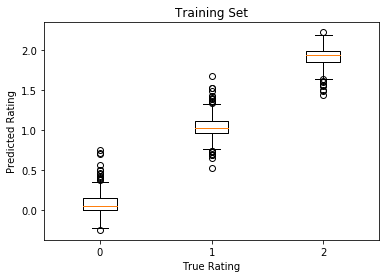

In [18]:
MakeBoxplot(Y_pred_gibbs, Y, R_train, 'Training Set')

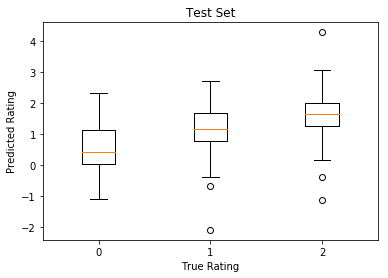

In [19]:
MakeBoxplot(Y_pred_gibbs, Y, R_test, 'Test Set')

The FCP (87/133) for the test set is similar to what we got in [collaborative_filtering.ipynb](https://github.com/liyenhsu/restaurant-data-with-consumer-ratings/blob/master/collaborative_filtering.ipynb) (86/133). 